In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Load and prepare data

In [3]:
import os, sys, pystan
import numpy as np
from pandas import read_csv
from notorious.io import load_model, save_fit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = 'pit_m1_np'

## Version
version = 1

## Sampling parameters.
samples = 2500
warmup = 2000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and preprocess data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv(os.path.join('data','data.csv'))

## Reject participants.
reject = read_csv(os.path.join('data','reject.csv'))
data = data.merge(reject[['Subject','Reject']]).query('Reject==False')

## Limit to version.
data = data.query(f'Version=={version}')
if version == 2: data['Block'] = 1

## Define robot identities.
data.loc[np.logical_and(data.Valence=='Win',data.Action=='Go'),'Robot'] = 'GW'
data.loc[np.logical_and(data.Valence=='Win',data.Action=='No-Go'),'Robot'] = 'NGW'
data.loc[np.logical_and(data.Valence=='Lose',data.Action=='Go'),'Robot'] = 'GAL'
data.loc[np.logical_and(data.Valence=='Lose',data.Action=='No-Go'),'Robot'] = 'NGAL'

## Define exposure.
f = lambda x: np.arange(x.size)+1
data['Exposure'] = data.groupby(['Subject','Block','Robot']).Trial.transform(f)
data = data.sort_values(['Version','Subject','Block','Robot','Exposure']).reset_index(drop=True)

## Update outcomes.
data['Outcome'] = data['Outcome'].replace({10:1, -10:-1})

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Assemble data for Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define data.
R = data.pivot_table('Outcome',('Subject','Block','Robot'),'Exposure').values.T
Y = data.pivot_table('Choice',('Subject','Block','Robot'),'Exposure').values.T

## Define mappings.
sub_ix = data.pivot_table('Choice',('Subject','Block','Robot'),'Exposure').index.get_level_values(0)
sub_ix = np.unique(sub_ix, return_inverse=True)[-1] + 1

## Define metadata.
T, H = Y.shape

## Assemble data.
dd = dict(H=H, T=T, Y=Y, R=R, sub_ix=sub_ix)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Load StanModel
StanModel = load_model(os.path.join('stan_models',stan_model))

## Fit model.
StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, 
                             thin=thin, n_jobs=n_jobs, seed=47404)

## Save.
f = os.path.join('stan_results','pilot%0.2d_%s' %(version,stan_model))
save_fit(f, StanFit, data=dd)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6c543d090887843c37bf0fcbe66e146 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [4]:
samples = StanFit.extract()

In [ ]:
sns.scatterplot(data.groupby('Subject').Accuracy.mean(), np.median(samples['rho'], axis=0))

In [ ]:
sns.scatterplot(data.groupby('Subject').Accuracy.mean(), np.median(samples['eta'], axis=0))

In [ ]:
ax = sns.scatterplot(data.groupby('Subject').Accuracy.mean(), np.median(samples['nu'], axis=0))
ax.set(xlabel='Overall Accuracy', ylabel='Pavlovian Bias')

sns.despine()
plt.tight_layout()

In [ ]:
pavlovian_subjects = data.Subject.unique()[np.where(np.median(samples['nu'], axis=0) > 1.5)]
pavlovian_subjects = data[data.Subject.isin(pavlovian_subjects)]


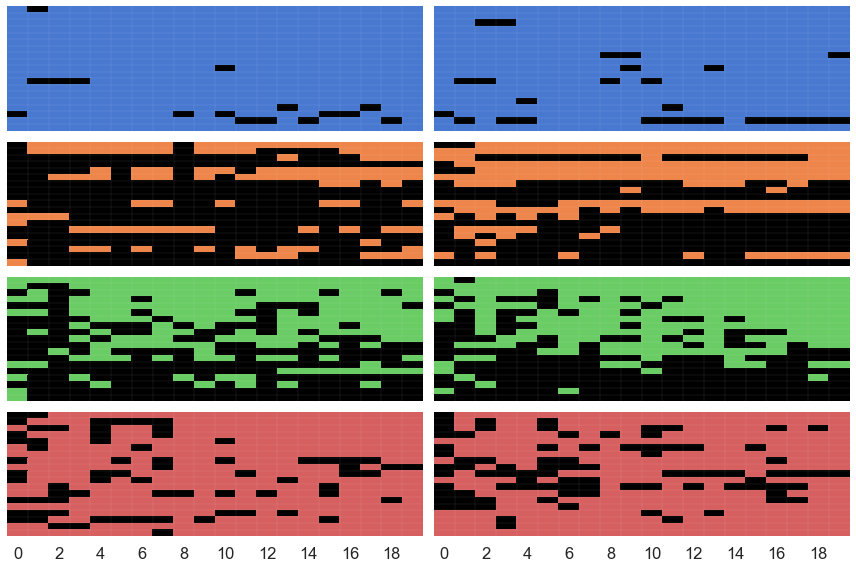

In [22]:
fig, axes = plt.subplots(4,2,figsize=(12,8),sharex=True,sharey=True)
palette = sns.color_palette('muted',n_colors=4)

pivot = data.pivot_table('Accuracy',('Block','Robot','Subject'),'Exposure')
ix = np.argsort(data.query('Robot=="GAL"').groupby('Subject').Accuracy.mean())[::-1]

for i, block in enumerate([1,2]):
    
    for j, (robot, color) in enumerate(zip(['GW','NGW','GAL','NGAL'], palette)):
        
        ## Extract data.
        acc = pivot.loc[block,robot].values[ix]
        n, m = acc.shape
        
        sns.heatmap(acc, cbar=False, cmap=['k',color], ax=axes[j,i])
        axes[j,i].hlines(np.arange(1,n),0,m,color='w',alpha=0.05)
        axes[j,i].vlines(np.arange(1,m),0,n,color='w',alpha=0.05)
        axes[j,i].set(yticks=[])
    
plt.tight_layout()

So, as an FYI, if you're still planning on piloting tomorrow: I've been modeling the pilot PIT data this afternoon. I've been starting with the simple 4-parameter PIT models (i.e. learning rate, reward sensitivity, go bias, Pavlovian bias). Here the reward sensitivity acts as the inverse temperature. I model the go bias and Pavlovian bias as scalar multiples of the reward sensitivity so that we can interpret how much influence a bias exerts relative to reward (e.g. a go bias = 0.5 says that the go-bias exerts roughly half as much influence as reward).